In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import healpy as hp
import pickle as pkl
import os

import GCRCatalogs
from GCRCatalogs import GCRQuery
from GCRCatalogs.helpers.tract_catalogs import tract_filter
GCRCatalogs.set_root_dir("/data/scratch/dc2_nfs/")

We specify the path at which we'll save the pkl file:

In [2]:
file_name = "dc2_lensing_catalog.pkl"
file_path = os.path.join("/data", "scratch", "dc2local", file_name)
file_already_populated = os.path.isfile(file_path)

---

### Truth

We load in the truth catalog and list all available quantities:

In [3]:
truth_cat = GCRCatalogs.load_catalog('desc_dc2_run2.2i_dr6_truth')

In [4]:
truth_cat.list_all_quantities()

['flux_i',
 'dec',
 'is_nearest_neighbor',
 'patch',
 'redshift',
 'mag_z',
 'av',
 'mag_i',
 'mag_u',
 'cosmodc2_hp',
 'tract',
 'cosmodc2_id',
 'is_good_match',
 'match_objectId',
 'id_string',
 'flux_r',
 'is_unique_truth_entry',
 'mag_r',
 'mag_g',
 'match_sep',
 'id',
 'flux_y',
 'host_galaxy',
 'truth_type',
 'flux_g',
 'rv',
 'flux_u',
 'ra',
 'mag_y',
 'flux_z']

And we fetch the variables we want. DC2 images are only available for tracts 3828 and 3829, so we'll load in the catalog for those two tracts and the tracts that surround them (see [here](https://arxiv.org/pdf/2101.04855)).

In [5]:
truth_df = truth_cat.get_quantities(
    quantities = ["cosmodc2_id", "id", "match_objectId", "tract",
                  "truth_type", "ra", "dec", "redshift",
                  "flux_u", "flux_g", "flux_r", "flux_i", "flux_z", "flux_y",
                  "mag_u", "mag_g", "mag_r", "mag_i", "mag_z", "mag_y"],
    native_filters = [tract_filter([3634, 3635, 3636, 3827, 3828, 3829, 3830, 4025, 4026, 4027])]
)

truth_df = pd.DataFrame(truth_df)

We see that there are around 47 million objects in the truth table:

In [6]:
truth_df.shape

(47003941, 20)

A small number of these objects are stars or supernovae rather than galaxies, so we filter those out:

In [7]:
truth_df = truth_df[truth_df['truth_type'] == 1]

In [8]:
truth_df.shape

(46707830, 20)

We also only include galaxies with an r-band flux greater than or equal to 200:

In [9]:
truth_df = truth_df[truth_df['flux_r'] >= 200]

In [10]:
truth_df.shape

(3644115, 20)

We create an ra/dec filter that we'll apply to CosmoDC2, as well as an equivalent (but faster) healpix filter:

In [11]:
max_ra = np.nanmax(truth_df['ra'])
min_ra = np.nanmin(truth_df['ra'])
max_dec = np.nanmax(truth_df['dec'])
min_dec = np.nanmin(truth_df['dec'])
ra_dec_filters = [f'ra >= {min_ra}', f'ra <= {max_ra}', f'dec >= {min_dec}', f'dec <= {max_dec}']

In [12]:
vertices = hp.ang2vec(np.array([min_ra, max_ra, max_ra, min_ra]),
                      np.array([min_dec, min_dec, max_dec, max_dec]), lonlat=True)
ipix = hp.query_polygon(32, vertices, inclusive=True)
healpix_filter = GCRQuery((lambda h: np.isin(h, ipix, True), "healpix_pixel"))

Here are the ID variables in the truth table:

In [13]:
truth_df[['cosmodc2_id', 'id', 'match_objectId']]

,cosmodc2_id,id,match_objectId
2,8752812073,8752812073,15982501021353397
3,8750045581,8750045581,15982501021353414
6,8753086049,8753086049,15982501021353424
8,8754413350,8754413350,15982501021353429
9,8750034610,8750034610,15982501021353441
...,...,...,...
47002668,6957691268,6957691268,-1
47002829,6957696291,6957696291,-1
47003046,6957702953,6957702953,-1
47003118,6957706339,6957706339,-1


We see that `id` and `cosmodc2_id` are equivalent, at least for galaxies:

In [14]:
(truth_df['cosmodc2_id'] == truth_df['id']).mean()

1.0

And note that a small number of galaxies are not matched in the object table (e.g., because they are blended or faint), while the remaining are matched:

In [15]:
print((truth_df['match_objectId'] == -1).sum())
print((truth_df['match_objectId'] > -1).sum())

228226
3415889


### Object-with-truth–match

We load in the object-with-truth-match catalog and list all available quantities:

In [16]:
object_truth_cat = GCRCatalogs.load_catalog('desc_dc2_run2.2i_dr6_object_with_truth_match')

In [17]:
object_truth_cat.list_all_quantities()

['flux_r_truth',
 'cModelFlux_g',
 'xErr',
 'mag_i_cModel',
 'IxyPSF_pixel_z',
 'parentObjectId',
 'psFlux_z',
 'av_truth',
 'flux_z_truth',
 'I_flag_i',
 'match_sep',
 'psFlux_u',
 'x',
 'magerr_z_cModel',
 'snr_u_cModel',
 'magerr_g',
 'patch',
 'mag_z',
 'psFluxErr_g',
 'magerr_z',
 'psFlux_flag_y',
 'id_truth',
 'snr_g_cModel',
 'snr_z_cModel',
 'I_flag_g',
 'cModelFlux_i',
 'mag_r',
 'Ixy_pixel_u',
 'IxyPSF_pixel_g',
 'Ixy_pixel',
 'cModelFlux_flag_r',
 'IyyPSF_pixel_r',
 'psNdata',
 'magerr_r',
 'Ixx_pixel_z',
 'mag_u_cModel',
 'magerr_y_cModel',
 'IxyPSF_pixel_r',
 'patch_truth',
 'IyyPSF_pixel_i',
 'cModelFlux_flag_g',
 'is_nearest_neighbor',
 'psf_fwhm_r',
 'ra_truth',
 'clean',
 'psf_fwhm_y',
 'IyyPSF_pixel_g',
 'psFlux_y',
 'psFluxErr_y',
 'flux_y_truth',
 'Ixx_pixel_r',
 'id_string_truth',
 'Ixy_pixel_g',
 'cModelFlux_flag_z',
 'mag_r_cModel',
 'magerr_r_cModel',
 'truth_type',
 'Iyy_pixel',
 'dec_truth',
 'Ixy_pixel_i',
 'magerr_g_cModel',
 'mag_u',
 'psFluxErr_u',
 'cMode

And we fetch the variables we want:

In [18]:
object_truth_df = object_truth_cat.get_quantities(
    quantities = ["cosmodc2_id_truth", "Ixx_pixel", "Iyy_pixel", "Ixy_pixel",
                  "IxxPSF_pixel_u", "IxxPSF_pixel_g", "IxxPSF_pixel_r", "IxxPSF_pixel_i", "IxxPSF_pixel_z", "IxxPSF_pixel_y", 
                  "IyyPSF_pixel_u", "IyyPSF_pixel_g", "IyyPSF_pixel_r", "IyyPSF_pixel_i", "IyyPSF_pixel_z", "IyyPSF_pixel_y",
                  "IxyPSF_pixel_u", "IxyPSF_pixel_g", "IxyPSF_pixel_r", "IxyPSF_pixel_i", "IxyPSF_pixel_z", "IxyPSF_pixel_y",
                  "psf_fwhm_u", "psf_fwhm_g", "psf_fwhm_r", "psf_fwhm_i", "psf_fwhm_z", "psf_fwhm_y"],
    filters = ra_dec_filters,
    native_filters = [tract_filter([3634, 3635, 3636, 3827, 3828, 3829, 3830, 4025, 4026, 4027])]
)

object_truth_df = pd.DataFrame(object_truth_df)

We see that there are around 11 million objects in the object-truth table:

In [19]:
object_truth_df.shape

(11116203, 28)

We don't need to explicitly filter out stars, supernovae, and faint galaxies as we did above, as this will happen implicitly when we merge `object_truth_df` with `truth_df`.

---

### CosmoDC2

Next, we load in CosmoDC2 and list all available quantities:

In [20]:
config_overwrite = dict(
    catalog_root_dir='/data/scratch/dc2_nfs/cosmoDC2_v1.1.4'
)

cosmo_cat = GCRCatalogs.load_catalog('desc_cosmodc2', config_overwrite)

In [21]:
cosmo_cat.list_all_quantities()

['Mag_true_z_sdss_z0',
 'sed_5148_319_bulge',
 'sed_8846_549_disk',
 'Mag_true_g_lsst_z0_no_host_extinction',
 'size_minor_true',
 'ellipticity_2_true',
 'mag_true_r_lsst_no_host_extinction',
 'ellipticity_2_disk_true',
 'mag_g_lsst',
 'sed_1933_474_bulge_no_host_extinction',
 'sed_3812_236_disk',
 'sed_1246_306_disk',
 'sed_9395_583_bulge',
 'sed_11467_1710',
 'sed_5467_339',
 'mag_true_i',
 'sed_1933_474_disk_no_host_extinction',
 'Mag_true_u_sdss_z0',
 'mag_true_y_lsst_no_host_extinction',
 'sed_17402_2596_no_host_extinction',
 'sed_11467_1710_disk',
 'mag_Y_lsst_no_host_extinction',
 'sed_4565_283_bulge',
 'sed_9395_583_no_host_extinction',
 'sed_2407_591_bulge',
 'Mag_true_u_lsst_z0_no_host_extinction',
 'sed_11467_1710_bulge_no_host_extinction',
 'R_v',
 'Mag_true_i_lsst_z0_no_host_extinction',
 'sed_6548_406_disk',
 'sed_7843_486',
 'mag_r',
 'ellipticity_bulge_true',
 'ellipticity_1_disk_true_dc2',
 'mag_true_y',
 'mag_i_lsst_no_host_extinction',
 'sed_1246_306',
 'sed_3812_236

And we fetch the variables we want.

Some notes:
- We only pull objects in the ra/dec region from the truth table, using the filters defined above.
- ellipticity_1_true_dc2 and ellipticity_2_true_dc2 are the unlensed ellipticities that were used in the DC2 images (i.e., shear and convergence were applied to these ellipticities). ellipticity_1_true and ellipticity_2_true are the unlensed ellipticities from a subsequent bug fix described in section 2.4 of [this paper](https://arxiv.org/pdf/2101.04855). Ideally we'd want the lensed versions ellipticity_1 and ellipticity_2, which are listed [here](https://github.com/LSSTDESC/gcr-catalogs/blob/master/GCRCatalogs/SCHEMA.md) but are not available (see the above list).

In [22]:
cosmo_df = cosmo_cat.get_quantities(
    quantities = ["galaxy_id", "ra", "dec",
                  "ellipticity_1_true", "ellipticity_2_true",
                  "ellipticity_1_true_dc2", "ellipticity_2_true_dc2",
                  "shear_1", "shear_2", "convergence"],
    filters = ra_dec_filters,
    native_filters = healpix_filter
)
cosmo_df = pd.DataFrame(cosmo_df)

We see that there are around 135 million galaxies in CosmoDC2:

In [23]:
cosmo_df.shape

(134746549, 10)

The history saving thread hit an unexpected error (OperationalError('disk I/O error')).History will not be written to the database.


---

### Merge `truth_df` and `object_truth_df`

We merge the truth table with the object-with-truth-match table using CosmoDC2 ID:

In [24]:
merge_df1 = truth_df.merge(
    object_truth_df, 
    left_on = "cosmodc2_id",
    right_on = "cosmodc2_id_truth", 
    how = "left"
)

We remove duplicate `cosmodc2_id`s. These arise because a small number of measured objects in `object_truth_df` are matched with the same `cosmodc2_id` in the truth table. But the only columns of `object_truth_df` that we are using are the `_truth` columns, so our merged data frame has the same truth values listed multiple times (as opposed to slighly different measured values corresponding to the multiple objects that were matched to the same `cosmodc2_id`).

In [25]:
merge_df1.drop_duplicates(subset = ['cosmodc2_id'], inplace = True)

Now `merge_df1` has the same number of rows as `truth_df`, as expected:

In [26]:
merge_df1.shape

(3644115, 48)

We drop `cosmodc2_id_truth` since it's not needed anymore:

In [27]:
merge_df1.drop(columns = ["cosmodc2_id_truth"], inplace = True)

---

### Merge `merge_df1` and `cosmo_df`

And now we merge the above data frame with CosmoDC2, again using CosmoDC2 ID (which is called `galaxy_id` in `cosmo_df`):

In [28]:
merge_df2 = merge_df1.merge(
    cosmo_df,
    left_on = "cosmodc2_id",
    right_on = "galaxy_id",
    how = "left"
)

As expected, the new data frame has the same number of rows as `merge_df1`:

In [29]:
merge_df2.shape

(3644115, 57)

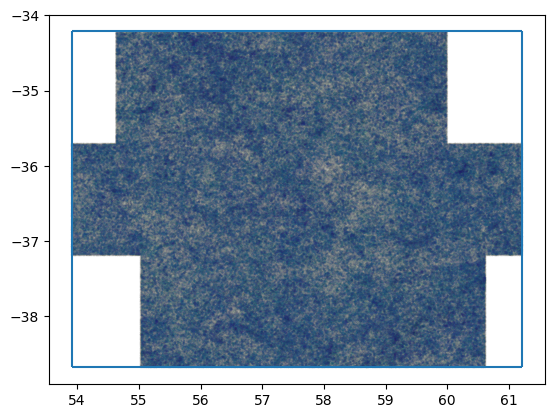

In [30]:
_ = plt.scatter(merge_df2['ra_x'], merge_df2['dec_x'],
                c = merge_df2['redshift'], alpha = 0.005, s = 1)
_ = plt.vlines(x = [min_ra, max_ra], ymin = max_dec, ymax = min_dec)
_ = plt.hlines(y = [min_dec, max_dec], xmin = min_ra, xmax = max_ra)

Here is the distribution of per-band magnitude and the distribution of redshift:

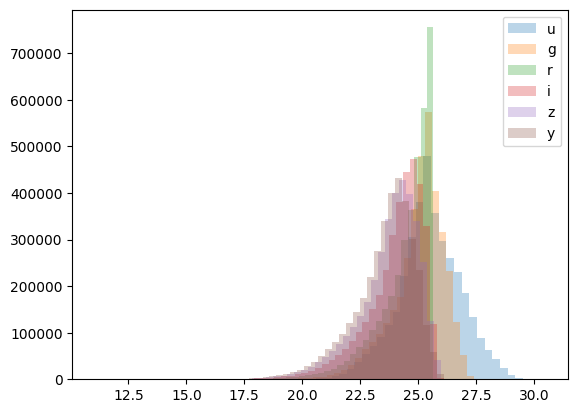

In [31]:
_ = plt.hist(merge_df2['mag_u'], bins = 50, alpha = 0.3, label = 'u')
_ = plt.hist(merge_df2['mag_g'], bins = 50, alpha = 0.3, label = 'g')
_ = plt.hist(merge_df2['mag_r'], bins = 50, alpha = 0.3, label = 'r')
_ = plt.hist(merge_df2['mag_i'], bins = 50, alpha = 0.3, label = 'i')
_ = plt.hist(merge_df2['mag_z'], bins = 50, alpha = 0.3, label = 'z')
_ = plt.hist(merge_df2['mag_y'], bins = 50, alpha = 0.3, label = 'y')
_ = plt.legend()

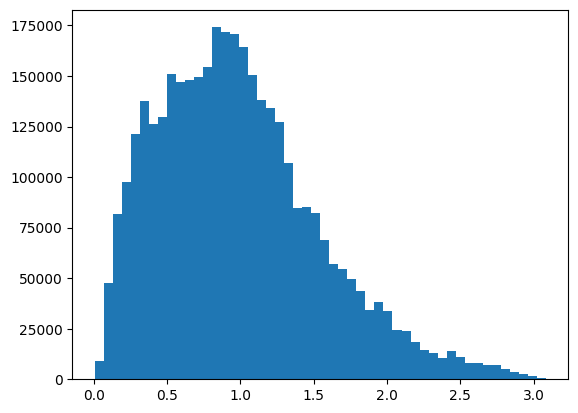

In [32]:
_ = plt.hist(merge_df2['redshift'], bins = 50)

And now we can examine shear and convergence, which were initially in `cosmo_df`:

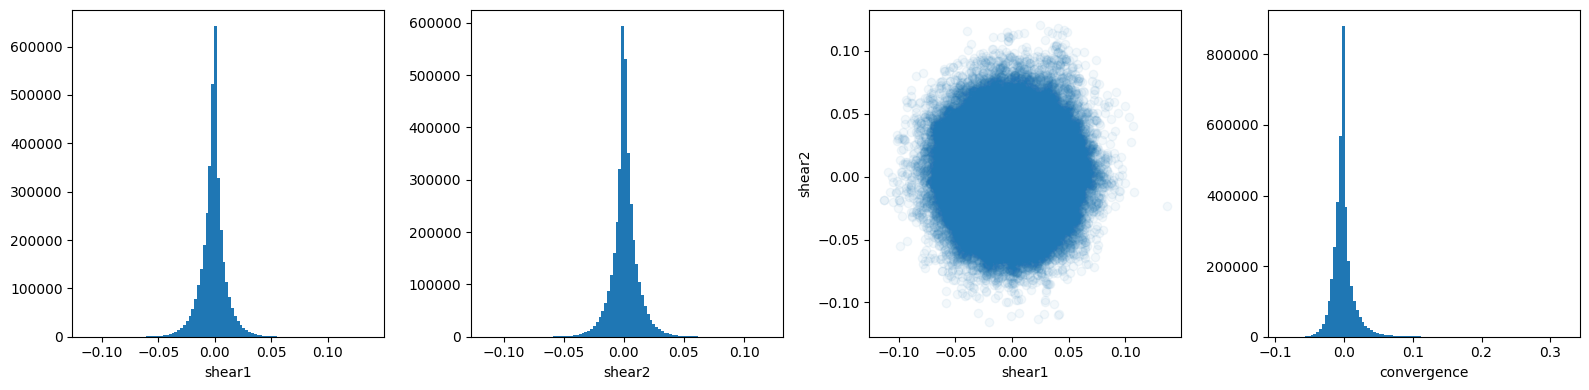

In [33]:
fig, ax = plt.subplots(1, 4, figsize = (16,4))
_ = ax[0].hist(merge_df2['shear_1'], bins = 100)
_ = ax[0].set_xlabel('shear1')
_ = ax[1].hist(merge_df2['shear_2'], bins = 100)
_ = ax[1].set_xlabel('shear2')
_ = ax[2].scatter(merge_df2['shear_1'], merge_df2['shear_2'], alpha = 0.05)
_ = ax[2].set_xlabel('shear1')
_ = ax[2].set_ylabel('shear2')
_ = ax[3].hist(merge_df2['convergence'], bins = 100)
_ = ax[3].set_xlabel('convergence')
fig.tight_layout()

In [34]:
merge_df2.shape

(3644115, 57)

We remove `ra_y` and `dec_y` since they're the same as `ra_x` and `dec_x`, respectively:

In [35]:
merge_df2.drop(columns = ['ra_y', 'dec_y'], inplace = True)

And then we rename `ra_x` and `dec_x` to `ra` and `dec`, respectively:

In [36]:
merge_df2.rename(columns = {
    "ra_x": "ra",
    "dec_x": "dec"
}, inplace = True)

---

Finally, we save `merge_df2` to `file_path`:

In [37]:
# with open(file_path, "wb") as f:
#     pkl.dump(merge_df2, f)